In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.utils import compute_sample_weight
from sklearn.metrics import balanced_accuracy_score
from plot_learning_curve import plot_learning_curve, plot_validation_curve
import matplotlib.pyplot as plt
from sklearn import preprocessing

None


### Loading and Preprocessing Data

In [2]:
adult_train = pd.read_csv("adult-t.tsv", sep = "\t")
adult_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,42.0,4,308770.0,15,10.0,2,1,0,2,1,0.0,0.0,40.0,39,0
1,23.0,4,520231.0,15,10.0,4,10,1,4,0,0.0,0.0,45.0,39,1
2,27.0,4,164924.0,11,9.0,4,3,1,4,1,0.0,0.0,40.0,39,1
3,29.0,6,198286.0,9,13.0,4,10,1,4,0,0.0,0.0,40.0,39,1
4,32.0,4,197505.0,11,9.0,4,1,3,4,0,0.0,0.0,40.0,39,1


In [3]:
adult_train = pd.get_dummies(adult_train, columns=['workclass', 'education', 'sex', 'occupation', 'relationship', 'race', 'native-country', 'marital-status'])
adult_train.shape

(10000, 108)

In [4]:
adult_train['target'].value_counts()/adult_train.shape[0]

1    0.7641
0    0.2359
Name: target, dtype: float64

In [5]:
normalize_columns = ['age', 'fnlwgt', 'capital-gain','capital-loss','hours-per-week']
def normalize(columns):
  scaler = preprocessing.StandardScaler()
  adult_train[columns] = scaler.fit_transform(adult_train[columns])
normalize(normalize_columns)

In [6]:
X = adult_train[[c for c in adult_train.columns if c != 'target']]
y = adult_train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

### Trying Boosting Classifier without HyperParameter tunings 

In [7]:
base_clf = SVC()

In [8]:
base_clf.fit(X_train, y_train)
y_train_pred = base_clf.predict(X_train)
y_test_pred = base_clf.predict(X_test)
print("Train Accuracy: ", balanced_accuracy_score(y_train, y_train_pred))
print("Test Accuracy: ", balanced_accuracy_score(y_test, y_test_pred))

Train Accuracy:  0.7356434273534092
Test Accuracy:  0.7402424054189961


In [9]:
base_clf.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

### Generate Learning Curve & Validation Curve with default classifier

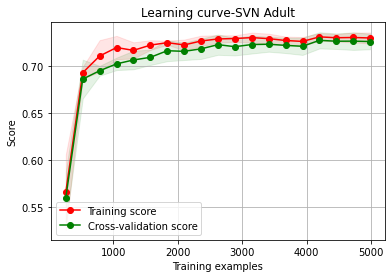

In [10]:
plot_learning_curve(base_clf, "Learning curve-SVN Adult", X_train, y_train, ylim=None, cv=4, n_jobs=-1)

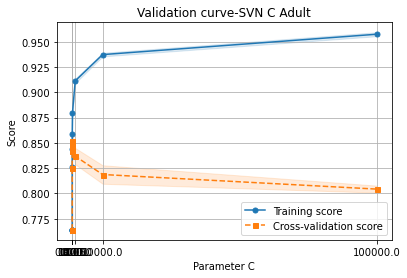

In [11]:
plot_validation_curve(base_clf, X_train, y_train, 'C', np.logspace(-5, 5, 11), cv=4, n_jobs=-1,scoring=make_scorer(balanced_accuracy_score), title="Validation curve-SVN C Adult")

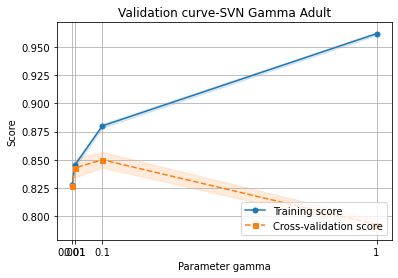

In [37]:
plot_validation_curve(base_clf, X_train, y_train, 'gamma', [1,0.1,0.01,0.001], cv=4, n_jobs=-1,scoring=make_scorer(balanced_accuracy_score), title="Validation curve-SVN Gamma Adult")

### Conducting GridSearch to obtain best HyperParameters

In [12]:
param_grid = {
    'C': np.logspace(-2, 4, 7),
    #'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf']
}

In [13]:
grid_search_rbf = GridSearchCV(base_clf, param_grid= param_grid, cv=4, scoring=make_scorer(balanced_accuracy_score), verbose=10, n_jobs=-1)
grid_search_rbf.fit(X_train, y_train)

Fitting 4 folds for each of 7 candidates, totalling 28 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done  16 out of  28 | elapsed:   41.1s remaining:   30.8s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:   51.4s remaining:   24.3s
[Parallel(n_jobs=-1)]: Done  22 out of  28 | elapsed:   57.5s remaining:   15.6s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:  1.4min remaining:   10.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:  2.0min finished


GridSearchCV(cv=4, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]),
                         'kernel': ['rbf']},
             scoring=make_scorer(balanced_accuracy_score), verbose=10)

In [14]:
grid_search_rbf.best_params_

{'C': 100.0, 'kernel': 'rbf'}

In [15]:
grid_search_rbf.best_estimator_

SVC(C=100.0)

In [16]:
grid_search_rbf.best_score_

0.7649814705581777

### Generating Learning Curve with tuned Hyperparameters

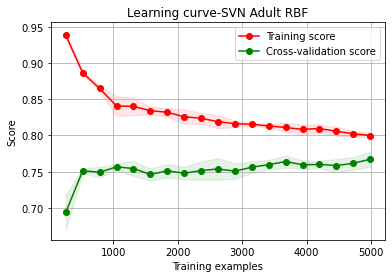

In [17]:
plot_learning_curve(grid_search_rbf.best_estimator_, "Learning curve-SVN Adult RBF", X_train, y_train, ylim=None, cv=4, n_jobs=-1)

In [18]:
param_grid = {
    'C': np.logspace(-5, 5, 11),
    #'gamma': [1,0.1,0.01,0.001],
    'kernel': ['sigmoid']
}

In [19]:
grid_search_sig = GridSearchCV(base_clf, param_grid= param_grid, cv=4, scoring=make_scorer(balanced_accuracy_score), verbose=10, n_jobs=-1)
grid_search_sig.fit(X_train, y_train)

Fitting 4 folds for each of 11 candidates, totalling 44 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done  34 out of  44 | elapsed:  1.2min remaining:   20.4s
[Parallel(n_jobs=-1)]: Done  39 out of  44 | elapsed:  1.3min remaining:    9.8s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:  1.4min finished


GridSearchCV(cv=4, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05]),
                         'kernel': ['sigmoid']},
             scoring=make_scorer(balanced_accuracy_score), verbose=10)

In [20]:
grid_search_sig.best_params_

{'C': 1.0, 'kernel': 'sigmoid'}

In [21]:
grid_search_sig.best_estimator_

SVC(kernel='sigmoid')

In [22]:
grid_search_sig.best_score_

0.532829074560459

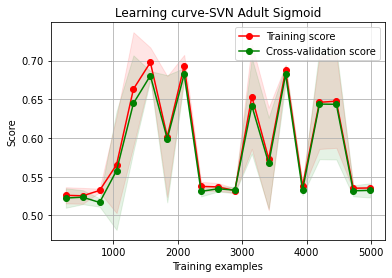

In [23]:
plot_learning_curve(grid_search_sig.best_estimator_, "Learning curve-SVN Adult Sigmoid", X_train, y_train, ylim=None, cv=4, n_jobs=-1)

### Fitting classifier with best parameters and calculating test score

In [25]:
best_clf = SVC(C=100.0)
best_clf.fit(X_train, y_train)
y_train_pred = best_clf.predict(X_train)
y_test_pred = best_clf.predict(X_test)
print("Train Accuracy: ", balanced_accuracy_score(y_train, y_train_pred))
print("Test Accuracy: ", balanced_accuracy_score(y_test, y_test_pred))

Train Accuracy:  0.7981981835082643
Test Accuracy:  0.7650930280711096


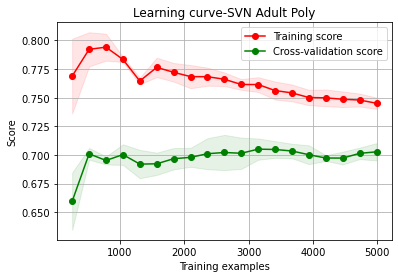

In [28]:
plot_learning_curve(SVC(kernel='poly', degree=8, gamma="auto"), "Learning curve-SVN Adult Poly", X_train, y_train, ylim=None, cv=4, n_jobs=-1)

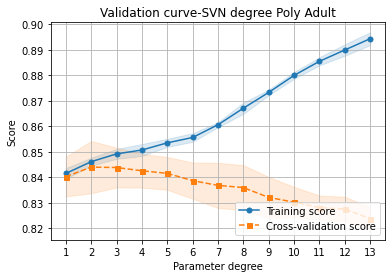

In [30]:
plot_validation_curve(SVC(kernel='poly', gamma="auto"), X_train, y_train, 'degree', [1,2,3,4,5,6,7,8,9,10,11,12,13], cv=4, n_jobs=-1,scoring=make_scorer(balanced_accuracy_score), title="Validation curve-SVN degree Poly Adult")

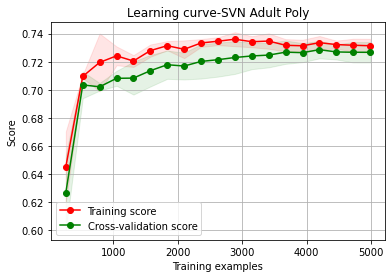

In [33]:
plot_learning_curve(SVC(kernel='poly', degree=2, gamma="auto"), "Learning curve-SVN Adult Poly", X_train, y_train, ylim=None, cv=4, n_jobs=-1)

In [35]:
best_clf = SVC(kernel='poly', degree=1, gamma="auto")
best_clf.fit(X_train, y_train)
y_train_pred = best_clf.predict(X_train)
y_test_pred = best_clf.predict(X_test)
print("Train Accuracy: ", balanced_accuracy_score(y_train, y_train_pred))
print("Test Accuracy: ", balanced_accuracy_score(y_test, y_test_pred))

Train Accuracy:  0.7295640716509728
Test Accuracy:  0.7371993965746739
